# ml-1m

In [1]:
# Apply fairness-aware data re-sampling (inspired by Ekstrand et al.) on ml-1m dataset for RecBole
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# 1. Load user profile, label interactions and original atomic interactions
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')  # user_id:token, gender, age, etc.
inter_df_label = pd.read_csv('../datasets/split_datasets/ml-1m/ml-1m.train.inter',
                             sep='\t')  # user_id:token, item_id:token, timestamp, label
inter_df_atomic = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.inter',
                              sep='\t')  # user_id:token, item_id:token, rating, timestamp

# 2. Merge rating into train.inter
inter_df = inter_df_label.merge(
    inter_df_atomic[['user_id:token', 'item_id:token', 'rating:float']],
    how='left',
    left_on=['user_id:token', 'item_id:token'],
    right_on=['user_id:token', 'item_id:token']
)

# 3. Merge gender info
merged_df = inter_df.merge(
    user_df[['user_id:token', 'gender:token']],
    on='user_id:token',
    how='left'
)

merged_df.rename(columns={'gender:token': 'gender'}, inplace=True)

display(merged_df.head())

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,1791,3949,974700700.0,1.0,4,M
1,1791,1084,974702340.0,1.0,3,M
2,1791,1805,974761150.0,0.0,2,M
3,1791,3897,974701200.0,1.0,4,M
4,1791,3741,974702400.0,1.0,4,M


In [2]:
# 4. Check gender distribution
female_df = merged_df[merged_df['gender'] == 'F']
male_df = merged_df[merged_df['gender'] == 'M']

female_user_count = female_df['user_id:token'].nunique()
female_positive = female_df[female_df['label:float'] == 1]
female_negative = female_df[female_df['label:float'] == 0]
female_interactions = len(female_df)
print(f"Female users: {female_user_count}, Female interactions: {female_interactions}")
print(f"Female interactions per user: {female_interactions / female_user_count:.4f}")
print(f"Female positive interactions: {len(female_positive)}")
print(f"Female positive ratio: {len(female_positive) / female_interactions:.4f}")

male_user_count = male_df['user_id:token'].nunique()
male_positive = male_df[male_df['label:float'] == 1]
male_negative = male_df[male_df['label:float'] == 0]
male_interactions = len(male_df)
print(f"Male users: {male_user_count}, Male interactions: {male_interactions}")
print(f"Male interactions per user: {male_interactions / male_user_count:.4f}")
print(f"Male positive interactions: {len(male_positive)}")
print(f"Male positive ratio: {len(male_positive) / male_interactions:.4f}")

Female users: 1709, Female interactions: 198620
Female interactions per user: 116.2200
Female positive interactions: 168129
Female positive ratio: 0.8465
Male users: 4331, Male interactions: 606823
Male interactions per user: 140.1115
Male positive interactions: 505428
Male positive ratio: 0.8329


In [3]:
# 5. Balance male/female interactions (undersample male group)
undersample_amount = male_user_count * (female_interactions / female_user_count)
positive_sample = int(undersample_amount * (len(female_positive) / female_interactions))
negtive_sample = int(undersample_amount * (1 - len(female_positive) / female_interactions))
print("if downsample male group:")
print(f"Need to sample {undersample_amount:.4f} male interactions.")
print(f"Need to sample {positive_sample} positive male interactions.")
print(f"Need to sample {negtive_sample} negative male interactions.")
male_positive_sampled = male_positive.sample(n=positive_sample, random_state=42)
male_negative_sampled = male_negative.sample(n=negtive_sample, random_state=42)

df_fair = pd.concat([female_df, male_positive_sampled, male_negative_sampled], ignore_index=True)

if downsample male group:
Need to sample 503348.8707 male interactions.
Need to sample 426077 positive male interactions.
Need to sample 77271 negative male interactions.


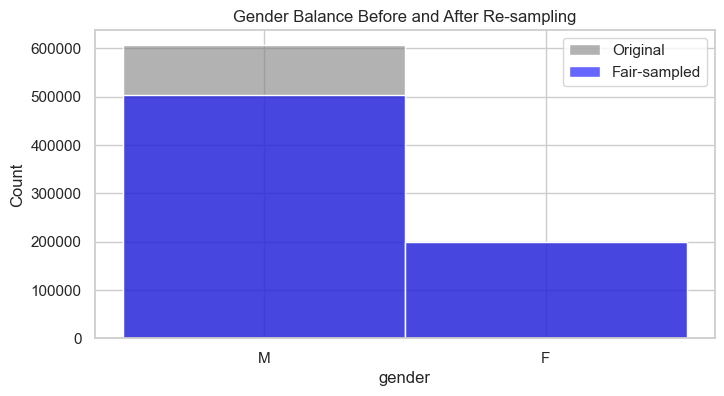

,user_id:token,item_id:token,timestamp:float,label:float,rating:float,gender
0,3067,2269,970001100.0,1.0,3,F
1,1503,1198,974748350.0,1.0,4,M
2,1303,1270,974788500.0,1.0,4,M
3,129,1214,977433400.0,1.0,5,M
4,2251,2,974601600.0,1.0,3,M


In [4]:
#shuffle balanced groups
df_fair = df_fair.sample(frac=1, random_state=42).reset_index(drop=True)

# 7. Optional: plot before and after
plt.figure(figsize=(8, 4))
sns.histplot(data=merged_df, x="gender", stat="count", color="gray", label="Original", alpha=0.6)
sns.histplot(data=df_fair, x="gender", stat="count", color="blue", label="Fair-sampled", alpha=0.6)
plt.title("Gender Balance Before and After Re-sampling")
plt.legend()
plt.show()

display(df_fair.head())

In [5]:
# 8. Save undersampled interaction set
import os

save_path = 'datasets/ml-1m/ml-1m.train.inter'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# 保存
df_fair[['user_id:token', 'item_id:token', 'timestamp:float', 'label:float']].to_csv(
    save_path,
    sep='\t',
    index=False
)
print(f"✅ Fair undersampled dataset saved to {save_path}")

✅ Fair resampled dataset saved to datasets/ml-1m/ml-1m.train.inter


In [6]:
import shutil

src_path = '../datasets/split_datasets/ml-1m/ml-1m.valid.inter'
dst_dir = 'datasets/ml-1m'
dst_path = os.path.join(dst_dir, 'ml-1m.valid.inter')

os.makedirs(dst_dir, exist_ok=True)

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

src_path = '../datasets/split_datasets/ml-1m/ml-1m.test.inter'
dst_path = os.path.join(dst_dir, 'ml-1m.test.inter')

# 复制文件
shutil.copyfile(src_path, dst_path)

print(f"✅ File copied to {dst_path}")

✅ File copied to datasets/ml-1m/ml-1m.valid.inter
✅ File copied to datasets/ml-1m/ml-1m.test.inter


In [7]:
from recbole.quick_start import run_recbole

run_recbole(config_file_list=['ml-1m-undersample.yaml'])

10 Jun 21:55    INFO  ['/Users/huangjiaqing/Desktop/Recommender Systems/RScode/.venv/lib/python3.10/site-packages/ipykernel_launcher.py', '-f', '/Users/huangjiaqing/Library/Jupyter/runtime/kernel-3cc4e955-1ad0-403b-a090-a4ca00e41d79.json']
10 Jun 21:55    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = checkpoint_saved/ml-1m/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', '

10 Jun 21:55    INFO  epoch 0 training [time: 2.90s, train loss: 463.2403]
10 Jun 21:55    INFO  epoch 0 evaluating [time: 1.34s, valid_score: 0.053600]
10 Jun 21:55    INFO  valid result: 
precision@10 : 0.0429    recall@10 : 0.0444    hit@10 : 0.3341    ndcg@10 : 0.0536    itemcoverage@10 : 0.0678    averagepopularity@10 : 1911.1151    shannonentropy@10 : 0.0108    giniindex@10 : 0.9966    tailpercentage@10 : 0.0018
10 Jun 21:55    INFO  Saving current: checkpoint_saved/ml-1m/BPR-Jun-10-2025_21-55-19.pth
10 Jun 21:55    INFO  epoch 1 training [time: 2.97s, train loss: 312.4355]
10 Jun 21:55    INFO  epoch 1 evaluating [time: 1.33s, valid_score: 0.057600]
10 Jun 21:55    INFO  valid result: 
precision@10 : 0.0455    recall@10 : 0.0482    hit@10 : 0.3555    ndcg@10 : 0.0576    itemcoverage@10 : 0.023    averagepopularity@10 : 1983.1619    shannonentropy@10 : 0.0284    giniindex@10 : 0.9972    tailpercentage@10 : 0.0003
10 Jun 21:55    INFO  Saving current: checkpoint_saved/ml-1m/BPR-Ju

{'best_valid_score': 0.0767,
 'valid_score_bigger': True,
 'best_valid_result': OrderedDict([('precision@10', 0.0577),
              ('recall@10', 0.0709),
              ('hit@10', 0.4475),
              ('ndcg@10', 0.0767),
              ('itemcoverage@10', 0.3793),
              ('averagepopularity@10', 1196.4564),
              ('shannonentropy@10', 0.004),
              ('giniindex@10', 0.9288),
              ('tailpercentage@10', 0.0003)]),
 'test_result': OrderedDict([('precision@10', 0.0582),
              ('recall@10', 0.072),
              ('hit@10', 0.4457),
              ('ndcg@10', 0.0765),
              ('itemcoverage@10', 0.3793),
              ('averagepopularity@10', 1196.4564),
              ('shannonentropy@10', 0.004),
              ('giniindex@10', 0.9288),
              ('tailpercentage@10', 0.0003)])}

In [8]:
from recbole.quick_start import load_data_and_model
from recbole.utils.case_study import full_sort_topk
from tqdm import tqdm
import pandas as pd
import numpy as np

# 1. 加载模型和数据
config, model, dataset, train_data, valid_data, test_data = load_data_and_model(
    model_file='checkpoint_saved/ml-1m/BPR-Jun-10-2025_21-55-19.pth'
)

# Step 1: Get all internal user IDs
all_uids = list(range(dataset.user_num))

# Step 2: Filter out users who have no interactions in the test set
valid_uids = [uid for uid in tqdm(all_uids) if test_data.uid2history_item[uid] is not None]

# Step 3: Convert to Series
uid_series = np.array(valid_uids)

# Step 4: Run full_sort_topk
topk_scores, topk_index = full_sort_topk(uid_series, model, test_data, k=10, device=config['device'])

# Step 5: Convert internal item IDs to external tokens
external_item_lists = [dataset.id2token(dataset.iid_field, row.cpu().tolist()) for row in topk_index]
external_user_list = [dataset.id2token(dataset.uid_field, [uid])[0] for uid in uid_series]
score_lists = [row.cpu().tolist() for row in topk_scores]

# load gender information
user_df = pd.read_csv('../datasets/atomic_datasets/ml-1m/ml-1m.user', sep='\t')
user_df['user_id:token'] = user_df['user_id:token'].astype(str)
user2gender = dict(zip(user_df['user_id:token'], user_df['gender:token']))

# Step 6: Save as DataFrame
df = pd.DataFrame({
    'user_id': external_user_list,
    'gender': [user2gender.get(uid, 'unknown') for uid in external_user_list],
    'topk_items': [','.join(items) for items in external_item_lists],
    'topk_scores': [','.join([f'{s:.4f}' for s in scores]) for scores in score_lists]
})
display(df.head())
print(df.nunique())
df.to_csv('../rank_results/ml-1m/ml_top10_undersample.csv', index=False)
print("save ml_top10_undersample successfully")

10 Jun 22:01    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = datasets/ml-1m
checkpoint_dir = checkpoint_saved/ml-1m/
show_progress = False
save_dataset = True
dataset_save_path = None
save_dataloaders = True
dataloaders_save_path = None
log_wandb = True

Training Hyper Parameters:
epochs = 100
train_batch_size = 1024
learner = adam
learning_rate = 0.0005
train_neg_sample_args = {'distribution': 'uniform', 'sample_num': 1, 'alpha': 1.0, 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [0.8, 0.1, 0.1]}, 'order': 'RO', 'group_by': 'user', 'mode': {'valid': 'full', 'test': 'full'}}
repeatable = True
metrics = ['Precision', 'Recall', 'Hit', 'NDCG', 'ItemCoverage', 'AveragePopularity', 'ShannonEntropy', 'GiniIndex', 'TailPercentage']
topk = [10]
valid_metric = NDCG@10
valid_metr

,user_id,gender,topk_items,topk_scores
0,3067,F,"3257,2291,1721,230,509,25,1407,1639,1704,3176","2.7862,2.7153,2.6824,2.6811,2.6548,2.6138,2.59..."
1,1503,M,"593,1196,858,110,2028,1221,1198,527,1617,2858","4.8660,4.8170,4.8112,4.6999,4.6055,4.5051,4.50..."
2,1303,M,"296,1089,2289,235,608,2455,1732,3476,32,1196","3.5071,3.3914,3.3798,3.3542,3.3374,3.3105,3.30..."
3,129,M,"6,2916,2278,1370,2058,3256,349,1527,3267,733","4.4904,4.0783,4.0649,3.7850,3.7650,3.7626,3.72..."
4,2251,M,"1259,1214,3362,1252,2455,1394,924,1179,1079,1278","2.9559,2.9507,2.9473,2.9196,2.9194,2.8725,2.86..."


user_id        6040
gender            2
topk_items     6040
topk_scores    6040
dtype: int64
save ml_top10_resample_down successfully
